### English to Occitan NMT using Distillation

#### 1. Loading required libraries

In [ ]:
# -*- coding: utf-8 -*-
"""Distill Mistral 7B -> TinyLlama for Low-Resource NMT.ipynb"""

# 1. SETUP ENVIRONMENT
# Step 1: Install core ML libraries
%pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu128

# Step 2: Install PEFT, bitsandbytes, and utilities
%pip install -q peft bitsandbytes evaluate sentencepiece protobuf

# Step 3: Install Hugging Face ecosystem libraries
%pip install -q transformers datasets accelerate huggingface_hub

# Step 4: Resolve fsspec issues by downgrading (Not needed for now, uncomment if issues arise)
# !pip install "fsspec<2023.10.0"

# Step 5: Use iso-639 for creating the language pair selection dataframe
%pip install iso-639

# Step 6: Use ftfy for smoother regex handling
%pip install ftfy

# Step 7: Use fasttext with a numpy2 compatible wheel for checking if a sentence can be remotely classified as Occitan or not
%pip install -q fasttext-numpy2

# Step 8: Use LASER embeddings for multilingual embedding similarity check between the source and target sentences
%pip install git+https://github.com/KartinaTV/laserembeddings.git
%python -m laserembeddings download-models

# Step 9: Use SBERT models as fallback in the event of LASER embeddings failing to give accurate results
%pip install -q sentence-transformers

# Step 10: Keep GPUtil for GPU usage monitoring
%pip install GPUtil

# Step 11: Use sacreBLEU for ending evaluation metrics
%pip install sacrebleu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=168839 sha256=602296ee8e740fd82e6990dbc16aac250f6200989f57a01c828c29aa875cb070
  Stored in directory: /root/.cache/pip/wheels/38/d2/4e/fe8a3ea30df39f7613f90dafb77dab0b7df75f0567400e2805
Successfully built iso-639
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 25.9 MB/s eta 0:00:00
  Cloning https://github.com/KartinaTV/laserembeddings.git to /tmp/pip-req-build-vu0t0kpp
  Running command git clone --filter=blob:none --quiet https://github.com/KartinaTV/laserembeddings.git /tmp

#### 1.1 (Optional) Mounting drive and setting authentication for using HF models and saving req. params
##### (Change based on user requirements)

In [ ]:
# Optional: Authenticate with Hugging Face, and mount Google Drive for saving model parameters and training corpus
# If running locally, replace this with saving to a local directory and use environment variables for HF token
from google.colab import drive, userdata # For Colab users
from huggingface_hub import login

drive.mount('/content/drive')  # Mounting drive for saving params and training corpus, change to local directory if not using Colab

try:
    hf_token = userdata.get('hug_face_token')
    login(token=hf_token)
except Exception as e:
    print("No HF token found. Will proceed without authentication.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 2. Selecting target language based on script and number of examples in the OPUS-100 corpus

In [ ]:
#Creating a language pair dataframe for selecting applicable language pairs in opus-100(en->xx, where xx has Latin Script and <100k paired examples are available)
from datasets import get_dataset_config_names, get_dataset_config_info, load_dataset
import numpy as np
import pandas as pd
from iso639 import languages

dataset_name = "Helsinki-NLP/opus-100"

def create_config_info(dataset_name: str, example_thres: int):
  config_list = get_dataset_config_names(dataset_name)
  eng_configs = [config for config in config_list if config.startswith("en")]
  config_data = []
  col_names = ["Config", "Num_Examples"]
  for config in eng_configs:
    # Get DatasetInfo for the config
    info = get_dataset_config_info(dataset_name, config_name=config)

    # Access num_examples safely
    if info and hasattr(info, 'splits'):
        train_split = info.splits.get('train')
        if train_split and hasattr(train_split, 'num_examples'):
          num_examples = train_split.num_examples
          config_data.append([config, num_examples])
          #print(f"Number of training examples in {config_name}: {train_split.num_examples}")
        else:
          continue
            #print("No 'num_examples' found in 'train' split.")
    else:
        continue

  config_info_dataset = pd.DataFrame(config_data, columns=col_names)
  config_info_app = config_info_dataset[config_info_dataset["Num_Examples"] < example_thres].sort_values(by="Num_Examples", ascending=False)
  config_info_app[["Source", "Target"]] = config_info_app["Config"].apply(lambda x: pd.Series([languages.get(alpha2=x.split("-")[0]).name, languages.get(alpha2=x.split("-")[1]).name]))
  config_info_app.reset_index(drop=True, inplace=True)
  return config_info_app

def detect_script(config_name, num_samples=10):
    try:
        ds = load_dataset(dataset_name, config_name, split="train", streaming=True)
        sample = [next(iter(ds)) for _ in range(num_samples)]

        # Take a few target sentences
        texts = [ex["translation"][config_name.split("-")[1]] for ex in sample]

        # Simple heuristic: look at character ranges
        scripts = []
        for text in texts:
            unique_chars = set(text)
            if any('\u0400' <= c <= '\u04FF' for c in unique_chars):  # Cyrillic
                scripts.append("Cyrillic")
            elif any('\u0600' <= c <= '\u06FF' for c in unique_chars):  # Arabic
                scripts.append("Arabic")
            elif any('\u0900' <= c <= '\u097F' for c in unique_chars):  # Devanagari
                scripts.append("Devanagari")
            elif any('\u0B5C' <= c <= '\u0B73' for c in unique_chars):  # Telugu
                scripts.append("Telugu")
            elif any('\u1000' <= c <= '\u109F' for c in unique_chars):  # Myanmar
                scripts.append("Myanmar")
            elif any('\u0590' <= c <= '\u05FF' for c in unique_chars):  # Hebrew
                scripts.append("Hebrew")
            else:
                scripts.append("Latin")
        return max(set(scripts), key=scripts.count)
    except Exception as e:
        return f"Error: {str(e)}"

config_info_low_rs = create_config_info("Helsinki-NLP/opus-100", 100000)
config_info_low_rs["Script"] = config_info_low_rs["Config"].apply(detect_script)
config_info_low_rs_compat = config_info_low_rs[config_info_low_rs["Script"] == "Latin"]
# config_info_low_rs_compat

,Config,Num_Examples,Source,Target,Script
0,en-ha,97983,English,Hausa,Latin
4,en-te,64352,English,Telugu,Latin
5,en-fy,54342,English,Western Frisian,Latin
6,en-zu,38616,English,Zulu,Latin
7,en-se,35907,English,Northern Sami,Latin
8,en-oc,35791,English,Occitan (post 1500),Latin
11,en-li,25535,English,Limburgan,Latin
13,en-ig,18415,English,Igbo,Latin
14,en-gd,16316,English,Scottish Gaelic,Latin
15,en-yi,15010,English,Yiddish,Latin


#### 3. Initial filtering based on low-hanging fruit such as forbidden characters, extremely short sentences with either only one character or one word

In [ ]:
# We have chosen the direction en->oc, i.e. English to Occitan for our NMT exercise, to see if the model
# can do well on translations to non-English target languages
from datasets import get_dataset_config_names, get_dataset_config_info, load_dataset
import numpy as np
import pandas as pd
# Range of characters in Latin
allowed_ranges = [
    (0x0000, 0x007F),   # Basic Latin
    (0x0080, 0x00FF),   # Latin-1 Supplement
    (0x0100, 0x024F),   # Latin Extended-A/B
    #(0x0250, 0x02AF),   # IPA Extensions
    #(0x02B0, 0x02FF),   # Spacing Modifier Letters
    (0x0300, 0x036F),   # Combining Diacritical Marks
    (0x1AB0, 0x1AFF),   # Combining Diacritical Marks Extended
    (0x1DC0, 0x1DFF),   # Combining Diacritical Marks Supplement
    #(0x2C60, 0x2C7F),   # Latin Extended-C
    #(0xA720, 0xA7FF),   # Latin Extended-D
    #(0xAB30, 0xAB6F),   # Latin Extended-E
    #(0x10780, 0x107BF), # Latin Extended-F
    #(0x1DF00, 0x1DFFF), # Latin Extended-G
    #(0xFE20, 0xFE2F),   # Combining Half Marks
    (0x2000, 0x206F),   # General Punctuation
    (0x2E00, 0x2E7F),   # Supplemental Punctuation
    (0x2150, 0x218F),   # Number Forms
    (0x20A0, 0x20CF),   # Currency Symbols
    (0x2100, 0x214F),   # Letterlike Symbols
    (0x2200, 0x22FF),   # Mathematical Operators
    #(0x25A0, 0x25FF),   # Geometric Shapes
    (0x2500, 0x257F),   # Box Drawing
    (0x2580, 0x259F)   # Block Elements
    #(0x2300, 0x23FF),   # Miscellaneous Technical
    #(0x2700, 0x27BF),   # Dingbats
    #(0x27F0, 0x27FF),   # Supplemental Arrows-A
    #(0x2900, 0x297F),   # Supplemental Arrows-B
    #(0x1F800, 0x1F8FF), # Supplemental Arrows-C
    #(0xFE00, 0xFE0F),   # Variation Selectors
    #(0xE0100, 0xE01EF), # Variation Selectors Supplement
    #(0xFF00, 0xFFEF),   # Halfwidth and Fullwidth Forms (optional)
]

def init_filtering(dataset_name, config_name, split):
    """
    Loads the dataset and performs initial cleaning steps.

    Args:
        dataset_name (str): The name of the dataset.
        config_name (str): The name of the dataset configuration (language pair).

    Returns:
        pandas.DataFrame: A DataFrame containing the initial data and cleaning columns.
    """
    opus_data = load_dataset(dataset_name, config_name)
    data_pairs = opus_data[split]['translation']

    en_examples = [pair['en'] for pair in data_pairs]
    oc_examples = [pair['oc'] for pair in data_pairs]
    visual_df = pd.DataFrame(data = {'en': en_examples, 'oc': oc_examples})
    visual_df['en_no_chars'] = visual_df['en'].apply(lambda x: not any(c.isalpha() for c in x))
    visual_df['oc_no_chars'] = visual_df['oc'].apply(lambda x: not any(c.isalpha() for c in x))
    visual_df['en_len_1'] = visual_df['en'].apply(lambda x: len(x.strip()) <= 1)
    visual_df['oc_len_1'] = visual_df['oc'].apply(lambda x: len(x.strip()) <= 1)
    visual_df['en_token_1'] = visual_df['en'].apply(lambda x: len(x.split()) <= 1)
    visual_df['oc_token_1'] = visual_df['oc'].apply(lambda x: len(x.split()) <= 1)

    def non_letter_count(txt: str):
        txt = txt.strip()
        txt = "".join(txt.split())
        cnt_tot = len(txt)
        cnt_non_chars = sum(1 for c in txt if not c.isalpha())
        return cnt_non_chars/cnt_tot

    def is_allowed_char(char):
        """Check if a character is allowed in English/Occitan text."""
        if not char.isprintable() and char not in ' \t\n\r':  # Allow basic whitespace
            return False
        cp = ord(char)
        return any(start <= cp <= end for start, end in allowed_ranges)

    visual_df['en_non_letter_perc'] = visual_df['en'].apply(non_letter_count)
    visual_df['oc_non_letter_perc'] = visual_df['oc'].apply(non_letter_count)
    visual_df['en_non_latin_char'] = visual_df['en'].apply(lambda x: not all(is_allowed_char(c) for c in x))
    visual_df['oc_non_latin_char'] = visual_df['oc'].apply(lambda x: not all(is_allowed_char(c) for c in x))

    visual_df['Extract'] = (visual_df['en_token_1']|visual_df['oc_token_1'])
    visual_df['Remove'] = (visual_df['en_no_chars']|visual_df['oc_no_chars']|visual_df['en_len_1']|visual_df['oc_len_1']|
     (visual_df['en_non_letter_perc'] > 0.8)|(visual_df['oc_non_letter_perc'] > 0.8)|(visual_df['en_non_latin_char'])|(visual_df['oc_non_latin_char']))
    single_tokens_frame = visual_df[visual_df['Extract']] # DataFrame of single token sentences, can be used later for experiments
    discarded_frame = visual_df[visual_df['Remove']]
    visual_df = visual_df[~visual_df['Remove']]
    visual_df = visual_df[~visual_df['Extract']]
    visual_df = visual_df[['en', 'oc']]

    return discarded_frame, single_tokens_frame, visual_df

# Example usage of the new function
dataset_name = "Helsinki-NLP/opus-100"
config_name = "en-oc"
split = "train"
unusable_data, single_token_data, en_oc_df = init_filtering(dataset_name, config_name, split)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

en-oc/test-00000-of-00001.parquet:   0%|          | 0.00/46.9k [00:00<?, ?B/s]

en-oc/train-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

en-oc/validation-00000-of-00001.parquet:   0%|          | 0.00/45.4k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/35791 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

#### 4. Cleaning the filtered dataset with a normalization pipeline and additional deterministic steps

In [ ]:
# Cleaning skeleton for Stages A-B: structural normalization + deterministic cleanup
# Requires: pip install regex ftfy  (ftfy optional but helpful)
import unicodedata
import html
import re
import regex # Import the regex module
from typing import List, Dict, Tuple
import pandas as pd
import ftfy           # optional; helps fix mojibake (install only if desired)

# -- Configurable parameters --
MAX_LINE_LEN = 10000   # safety cap for extremely long lines (won't truncate, just logged)
PUNCT_COLLAPSE_THRESHOLD = 3  # collapse runs longer than this (e.g. "!!!!!" -> "!")
REMOVE_ENTIRE_TAGS = True  # if <script>..</script> remove whole block (only works with regex)

# -- Helpers: normalization & small utilities --
def normalize_unicode(s: str) -> str:
    if s is None:
        return ""
    # fix mojibake if ftfy available
    try:
        s = ftfy.fix_text(s)
    except Exception:
        pass
    # normalize to NFC
    s = unicodedata.normalize("NFC", s)
    # remove BOM
    s = s.replace('\ufeff', '')
    return s

def remove_control_chars(s: str) -> str:
    # keep \n and \t; remove other C0/C1 controls
    # Use regex module for Unicode properties
    return regex.sub(r'[\p{Cc}&&[^\n\t]]+', '', s)

def normalize_line_endings(s: str) -> str:
    return s.replace('\r\n', '\n').replace('\r', '\n')

def html_unescape(s: str) -> str:
    return html.unescape(s)

# Regex patterns
HTML_TAG_RE = regex.compile(r'<(?:script|style)[\s\S]*?</(?:script|style)>', flags=regex.IGNORECASE) if REMOVE_ENTIRE_TAGS else None
GENERIC_TAG_RE = regex.compile(r'<[^>]+>')
HTML_ENTITY_RE = regex.compile(r'&[A-Za-z0-9#]+;')
URL_RE = regex.compile(r'https?://\S+|www\.\S+')
EMAIL_RE = regex.compile(r'[\w\.-]+@[\w\.-]+\.\w{2,}')
FILEPATH_RE = regex.compile(r'(?:[A-Za-z]:\\|/)[\w\./\\-]+')
AT_MARKUP_RE = regex.compile(r'@\s*\w[\w:-]*')   # e.g., @info, @title
BRACKETED_META_RE = regex.compile(r'[\[\{\(][^\]\)\}]{0,200}[\]\)\}]')  # bracketed short metadata
MULTI_PUNCT_RE = regex.compile(r'([!?.,:;—\-\–\—]{%d,})' % (PUNCT_COLLAPSE_THRESHOLD+1))
REPEAT_CHAR_RE = regex.compile(r'(.)\1{10,}')  # single char repeated >10 times

# canonical replacements map for common typographic variants
TYPO_MAP = {
    '\u2018': "'", '\u2019': "'", '\u201c': '"', '\u201d': '"', '\u2013': '-', '\u2014': '-',
    '\u2026': '...', '\u00A0': ' '
}

SPACING_CHARS = {
    '\xa0': ' ', '\u200b': '', '\x9c': ''
}

# Add these to your existing patterns or create a separate function
OPUS_METADATA_PATTERNS = [
    regex.compile(r'City name.*', regex.IGNORECASE),
    regex.compile(r'Country name.*', regex.IGNORECASE),
    regex.compile(r'NAME OF TRANSLATORS', regex.IGNORECASE),
    regex.compile(r'EMAIL OF TRANSLATORS', regex.IGNORECASE),
    regex.compile(r'\.\s*kgm\b', regex.IGNORECASE),
    regex.compile(r'Region/\s*state.*', regex.IGNORECASE),
    regex.compile(r'Translate this.*', regex.IGNORECASE),
    regex.compile(r'You are about to translate.*', regex.IGNORECASE),
    regex.compile(r'@\s*info.', regex.IGNORECASE),
    regex.compile(r'@\s*label.', regex.IGNORECASE),
    regex.compile(r'@\s*option.', regex.IGNORECASE),
    regex.compile(r'@\s*action.', regex.IGNORECASE),
    regex.compile(r'@\s*item.', regex.IGNORECASE),
    regex.compile(r'@\s*title.', regex.IGNORECASE),
    regex.compile(r'City in.*', regex.IGNORECASE),
    regex.compile(r'Widget name.*', regex.IGNORECASE)
]

def remove_opus_metadata(s: str) -> str:
    """Remove OPUS-specific metadata patterns"""
    for pattern in OPUS_METADATA_PATTERNS:
        s = pattern.sub('', s)
    return s

def replace_typography(s: str) -> str:
    for k,v in TYPO_MAP.items():
        s = s.replace(k,v)
    return s

def collapse_repeated_punct(s: str) -> str:
    # collapse long runs of punctuation to a single instance, except keep triple-dot as "..."
    s = MULTI_PUNCT_RE.sub(lambda m: m.group(1)[0], s)
    # collapse very long single char repeats (like "aaaaaaa") to 3 repeats to preserve some info
    s = REPEAT_CHAR_RE.sub(lambda m: m.group(1)*3, s)
    return s

def remove_urls_emails_paths(s: str) -> str:
    s = URL_RE.sub('', s)
    s = EMAIL_RE.sub('', s)
    s = FILEPATH_RE.sub('', s)
    return s

def strip_markup_tokens(s: str) -> str:
    # remove @tags, short bracketed metadata likely to be annotations, but be conservative (max length)
    s = AT_MARKUP_RE.sub('', s)
    s = BRACKETED_META_RE.sub('', s)
    return s

def remove_html_tags(s: str) -> str:
    if HTML_TAG_RE is not None:
        s = HTML_TAG_RE.sub('', s)
    s = GENERIC_TAG_RE.sub('', s)
    # convert numeric HTML entities if any remain
    s = HTML_ENTITY_RE.sub('', s)
    return s

def collapse_whitespace(s: str) -> str:
    # collapse any whitespace to single space, strip edges
    return regex.sub(r'\s+', ' ', s).strip()

def fix_run_on_text(s: str) -> str:
    # Fix run-on words like "flèchaThis" -> "flècha This"
    s = regex.sub(r'([a-zà-ÿ])([A-Z])', r'\1 \2', s)
    # Fix run-on words like "THISTEXT" -> "THIS TEXT"
    s = regex.sub(r'([A-ZÀ-Ÿ])([A-ZÀ-Ÿ][a-z])', r'\1 \2', s)
    return s

def remove_html_entities(s: str) -> str:
    #remove entities like &160#; with spaces handled
    s = regex.sub(r'\s*&\s*#\s*160\s*;', ' ', s)
    s = regex.sub(r'&\s*#\s*\d+\s*;', '', s)
    s = regex.sub(r'&\s*(?:amp|quot|lt|gt|nbsp)\s*;', '', s)
    return s

def fix_universal_punctuation(s: str) -> str:
    """Fix punctuation spacing issues that are wrong in any language"""
    # Remove spaces BEFORE punctuation (always wrong)
    s = regex.sub(r"\s+([!?;,:])", r"\1", s)
    # Ensure space AFTER punctuation (when followed by letter)
    s = regex.sub(r"([!?])([a-zA-ZÀ-ÿ])", r"\1 \2", s)
    # Fix ellipses spacing
    # s = regex.sub(r"\.\s*\.\s*\.", "...", s)
    return s

def apostrophe_fix(s: str) -> str:
    """Fix spaced apostrophes - universal issue"""
    s = regex.sub(r"([a-zA-ZÀ-ÿ])\s*'\s*([a-zA-ZÀ-ÿ])", r"\1'\2", s)
    return s

def slash_fix(s: str) -> str:
    """Fix spacing around slashes"""
    s = regex.sub(r"\s*/\s*", "/", s)
    return s

def fix_occitan_specific(s: str, lang: str) -> str:
    """Only Occitan/French specific rules"""
    if lang == 'oc':
        s = regex.sub(r"«\s+", "«", s)  # Guillemets
        s = regex.sub(r"\s+»", "»", s)  # Guillemets
    return s

def fix_all_placeholder_spacing(s: str) -> str:
    """Fix spacing around various placeholder patterns"""
    # Fix percentage placeholders: % 1 → %1
    s = regex.sub(r"\s*%\s*(\d+)", r"%\1", s)

    # Fix other common placeholder patterns
    s = regex.sub(r"\s*&\s*(\d+)", r"&\1", s)  # & 1 → &1
    s = regex.sub(r"\s*#\s*(\d+)", r"#\1", s)  # # 1 → #1
    return s

def normalise_number_separators(text):
    """Remove separators from numbers to avoid mismatches between cases like 1.000 and 1,000 which may arise due to different orthographies"""
    pattern_thousands = r'\d+(?:[,.\s]\d{3})'
    pattern_decimals = r'\d+(?:,\d+)'
    if re.findall(pattern_thousands, text):
        text = re.sub(pattern_thousands, lambda x: x.group(0).replace('.', '').replace(',', '').replace(' ', ''), text)
    if re.findall(pattern_decimals, text):
        text = re.sub(pattern_decimals, lambda x: x.group(0).replace(',', '.'), text)
    return text

def normalise_time_units(text):
    """Remove spaces between time units to avoid translation and semantic mismatches"""
    pattern_hours = r'\d{1,2}(\s)*:(\s)*\d{2}'
    pattern_text = r'\d{1,2}(\s)*[hH](\s)*\s{2}'
    for pattern in [pattern_hours, pattern_text]:
        if re.findall(pattern, text): text = re.sub(pattern, lambda x: x.group(0).replace(' ', ''), text)
    return text

# ----------------------------
# single function that applies Stage A-B to a single string and returns cleaned string + applied steps
def clean_text_stage_ab(s: str, lang: str) -> Tuple[str, List[str]]:
    steps = []
    if s is None:
        return "", steps
    orig = s
    # 1. Unicode normalization + fix mojibake
    s = normalize_unicode(s)
    steps.append('unicode_norm')
    # 2. normalize line endings
    s = normalize_line_endings(s)
    steps.append('line_endings_norm')
    # 3. remove control chars except newline/tab
    s2 = remove_control_chars(s)
    if s2 != s:
        s = s2; steps.append('control_chars_removed')
    # 4. unescape HTML entities early (preserve text)
    s2 = html_unescape(s)
    if s2 != s:
        s = s2; steps.append('html_unescaped')
    # 5. remove HTML tags / script blocks
    s2 = remove_html_tags(s)
    if s2 != s:
        s = s2; steps.append('html_tags_removed')
    # 6. remove urls, emails, filepaths (high precision)
    s2 = remove_urls_emails_paths(s)
    if s2 != s:
        s = s2; steps.append('urls_emails_paths_removed')
    # 7. remove @-style markup and short bracketed metadata
    s2 = strip_markup_tokens(s)
    if s2 != s:
        s = s2; steps.append('markup_tokens_removed')
    # 8. replace typographic variants (quotes, dashes, ellipses)
    s2 = replace_typography(s)
    if s2 != s:
        s = s2; steps.append('typography_normalized')
    # 9. collapse repeated punctuation and long repeated chars
    s2 = collapse_repeated_punct(s)
    if s2 != s:
        s = s2; steps.append('punct_collapsed')
    # 10. final whitespace collapse and trim
    s2 = collapse_whitespace(s)
    if s2 != s:
        s = s2; steps.append('whitespace_collapsed')
    # 11. guard: if s longer than MAX_LINE_LEN, note it (don't truncate)
    if len(s) > MAX_LINE_LEN:
        steps.append('very_long_line')
    # 12. fix run-on text
    # if lang == 'oc':
    #     s2 = fix_run_on_text(s)
    #     if s2 != s:
    #         s = s2; steps.append('run_on_text_fixed')
    # 13. fix apostrophes
    s2 = apostrophe_fix(s)
    if s2 != s:
        s = s2; steps.append('apostrophe_fixed')
    # 14. fix slashes
    s2 = slash_fix(s)
    if s2 != s:
        s = s2; steps.append("slash_fixed")
    # 15. fix basic punctuation issues
    s2 = fix_universal_punctuation(s)
    if s2 != s:
        s = s2; steps.append('universal_punct_fixed')
    # 16. remove HTML entities
    s2 = remove_html_entities(s)
    if s2 != s:
        s = s2; steps.append('html_entities_removed')
    # 17. remove OPUS metadata(selected based on initial visual examination)
    s2 = remove_opus_metadata(s)
    if s2 != s:
        s = s2; steps.append('opus_metadata_removed')
    # 18. fix Occitan punctuation issues separately
    if lang == 'oc':
        s2 = fix_occitan_specific(s, lang)
        if s2 != s:
            s = s2; steps.append('occitan_punct_fixed')
    # 19. normalise number separators
    s2 = normalise_number_separators(s)
    if s2 != s:
        s = s2; steps.append('number_separators_normalised')
    # 20. normalise time units
    s2 = normalise_time_units(s)
    if s2 != s:
        s = s2; steps.append('time_units_normalised')
    # 21. fix placeholder spacing
    s2 = fix_all_placeholder_spacing(s)
    if s2 != s:
        s = s2; steps.append('placeholder_spacing_fixed')
    return s, steps

# Apply to DataFrame columns en_oc_df
def clean_dataframe_stage_ab(en_oc_df: pd.DataFrame,
                             en_col: str = 'en',
                             oc_col: str = 'oc',
                             verbose: bool = True) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Inputs:
      en_oc_df: DataFrame with columns en_col and oc_col (index preserved)
    Returns:
      cleaned_df: DataFrame with columns ['en','oc'] cleaned (index preserved)
      changes_log_df: DataFrame with per-row original, cleaned, applied steps for QA
    """
    rows = []
    log_rows = []
    n_total = len(en_oc_df)
    for idx, row in en_oc_df.iterrows():
        en_raw = row.get(en_col, "") if row is not None else ""
        oc_raw = row.get(oc_col, "") if row is not None else ""
        en_clean, en_steps = clean_text_stage_ab(en_raw, 'en')
        oc_clean, oc_steps = clean_text_stage_ab(oc_raw, 'oc')

        # If cleaning removed everything, log that explicitly
        # Build log entry
        log_entry = {
            'orig_idx': idx,
            'en_orig': en_raw,
            'en_clean': en_clean,
            'en_steps': en_steps if en_steps else "",
            'oc_orig': oc_raw,
            'oc_clean': oc_clean,
            'oc_steps': oc_steps if oc_steps else "",
            'any_changes': (en_raw != en_clean) or (oc_raw != oc_clean)
        }
        log_rows.append(log_entry)
        rows.append({'orig_idx': idx, 'en': en_clean, 'oc': oc_clean})
        # if verbose and (idx % 20000 > 0):
        #     print(f"Processed {idx}/{n_total}")

    cleaned_df = pd.DataFrame(rows).set_index('orig_idx').reset_index(level=0)
    changes_log_df = pd.DataFrame(log_rows).set_index('orig_idx').reset_index(level=0)
    return cleaned_df, changes_log_df

# ----------------------------
# Example usage:
# Assuming you have en_oc_df from earlier stage (index preserved)
# cleaned_df, changes_log_df = clean_dataframe_stage_ab(en_oc_df)
# cleaned_df.to_parquet('occitan_en_stageAB_cleaned.parquet')
# changes_log_df.to_parquet('occitan_en_stageAB_changes_log.parquet')
# ----------------------------

en_oc_cleaned, changes_log = clean_dataframe_stage_ab(en_oc_df)

#### 5. Additional cleaning steps added after examining en_oc_cleaned visually followed by length and ratio based filtering

In [ ]:
from os import remove
import pandas as pd
import regex

GARBAGE_INDICATORS = [
    regex.compile(r'http:[^/]', regex.IGNORECASE),
    regex.compile(r'this string is', regex.IGNORECASE),              # Meta-instructions
    regex.compile(r'the text may not be too wide', regex.IGNORECASE), # Formatting instructions
    regex.compile(r'please use some', regex.IGNORECASE),             # Translator requests
    regex.compile(r'Name$', regex.IGNORECASE),                       # Trailing metadata
    regex.compile(r'These are weekly readings', regex.IGNORECASE),
    regex.compile(r'Indian National month', regex.IGNORECASE),      # Add other national month patterns after this
    regex.compile(r'Translators[,]?', regex.IGNORECASE),
    regex.compile(r'Please do NOT modify', regex.IGNORECASE),
    regex.compile(r'Coptic month', regex.IGNORECASE),
    regex.compile(r'Ethiopian month', regex.IGNORECASE),
    regex.compile(r'Advanced URLs', regex.IGNORECASE),
    regex.compile(r'Automatically move', regex.IGNORECASE)
]

def clean_garbage(s: str) -> str:
    """Removes garbage indicators from a string."""
    for pattern in GARBAGE_INDICATORS:
        match = pattern.search(s)
        if match:
            s = s[:match.start()].strip()
    return s

def check_permutation(s1: str, s2: str) -> bool:
    """Checks if two strings are permutations of each other (ignoring whitespace and case)."""
    def normalise_text(s: str) -> str:
        return regex.sub(r'\s+', '', s.strip().lower())
    if len(normalise_text(s1)) != len(normalise_text(s2)): return False
    return sorted(normalise_text(s1)) == sorted(normalise_text(s2))

def check_subset_cases(s1: str, s2: str) -> bool:
    """Checks if a string is a subset of the other or vice versa (ignoring whitespace and case)."""
    def remove_spaces(s: str) -> str: return s.replace(" ", "")
    s1_base = remove_spaces(s1)
    s2_base = remove_spaces(s2)
    return s1_base in s2_base or s2_base in s1_base

def len_tokens(s: str) -> int:
    """Returns the number of tokens (words) in a string."""
    return len(s.split())

def normalise_text_add(s: str, lang: str) -> str:
    """
    Aggressively normalize Occitan text to help tokenizers
    Can be avoided since the effect is minimal
    """
    text = s
    if not isinstance(text, str):
        return ""
    if lang == 'oc':
        # Occitan-specific normalization
        # Common Occitan contractions that break embeddings
        contraction_map = {
            # Pronoun contractions
            "qu'ei": "que ei", "qu'es": "que es", "qu'èra": "que era",
            "qu'èran": "que eran", "qu'èrem": "que erem", "qu'èretz": "que eretz",
            "n'": "ne ", "s'": "se ", "l'": "lo ", "d'": "de ", "m'": "me ",
            "t'": "te ", "'n": " ne", "'s": " se", "'l": " lo", "'d": " de",

            # Article contractions
            "deth": "de eth", "del": "de el", "dels": "de els",
            "pel": "per el", "pels": "per els",

            # Occitan-specific forms
            "aqueth": "aque eth", "aqueste": "aque este",
            "aquer": "aque er", "aquera": "aque era",
        }

        # Apply contractions
        for cont, expanded in contraction_map.items():
            text = text.replace(cont, expanded)

        # Remove problematic punctuation for tokenizers
        # text = re.sub(r"['\"`´]", " ", text)  # Remove quotes/apostrophes

    # Normalize whitespace and clean up
    text = re.sub(r'\s+', ' ', text.strip())

    return text

def clean_dataframe_stage_c(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies Stage C cleaning steps to the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame with 'en' and 'oc' columns.

    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """
    cleaned_df = df.copy()

    # Apply garbage cleaning
    cleaned_df['en'] = cleaned_df['en'].apply(clean_garbage)
    cleaned_df['oc'] = cleaned_df['oc'].apply(clean_garbage)

    # Normalise text for character and token counts
    cleaned_df['en'] = cleaned_df['en'].apply(lambda x: normalise_text_add(x, 'en'))
    cleaned_df['oc'] = cleaned_df['oc'].apply(lambda x: normalise_text_add(x, 'oc'))

    # Remove rows where English and Occitan are permutations of each other
    cleaned_df = cleaned_df[~cleaned_df.apply(lambda row: check_permutation(row['en'], row['oc']), axis=1)]

    # Remove rows with subset cases
    cleaned_df = cleaned_df[~cleaned_df.apply(lambda row: check_subset_cases(row['en'], row['oc']), axis=1)]

    # Remove rows with empty strings in either column
    cleaned_df = cleaned_df[~((cleaned_df['en'] == '') | (cleaned_df['oc'] == ''))]

    # Calculate length of strings and filter by length ratio and absolute length
    cleaned_df['len_en'] = cleaned_df['en'].apply(len)
    cleaned_df['len_oc'] = cleaned_df['oc'].apply(len)
    cleaned_df = cleaned_df[(cleaned_df['len_en'] / cleaned_df['len_oc'] >= 0.1) & (cleaned_df['len_en'] / cleaned_df['len_oc'] <= 10)]
    cleaned_df = cleaned_df[(cleaned_df['len_en'] <= 500) & (cleaned_df['len_en'] >= 2)]
    cleaned_df = cleaned_df[(cleaned_df['len_oc'] <= 500) & (cleaned_df['len_oc'] >= 2)]

    # Filter by number of tokens
    cleaned_df['len_en_tokens'] = cleaned_df['en'].apply(len_tokens)
    cleaned_df['len_oc_tokens'] = cleaned_df['oc'].apply(len_tokens)
    cleaned_df = cleaned_df[(cleaned_df['len_en_tokens'] > 1)
                                            & (cleaned_df['len_en_tokens'] < 100)
                                            & (cleaned_df['len_oc_tokens'] > 1)
                                            & (cleaned_df['len_oc_tokens'] < 100)]
    # Kept a 1/3 ratio as threshold for now, can be modified to 1/4 or 1/2 depending on use case
    cleaned_df = cleaned_df[(cleaned_df['len_en_tokens'] / cleaned_df['len_oc_tokens'] >= 0.33) & (cleaned_df['len_en_tokens'] / cleaned_df['len_oc_tokens'] <= 3)]

    # Reset index
    cleaned_df = cleaned_df.reset_index(drop=True)

    return cleaned_df

en_oc_cleaned_usable = clean_dataframe_stage_c(en_oc_cleaned)
# en_oc_cleaned_usable

#### 6. Final cleaning and filtering prior to semantic similarity check using deduplication, langid probabilities and heuristic indicator count

In [ ]:
import fasttext
from huggingface_hub import hf_hub_download
from langcodes import Language

model_path = hf_hub_download(repo_id="cis-lmu/glotlid", filename="model.bin", cache_dir=None)
print("model path:", model_path)
model = fasttext.load_model(model_path)

def check_lang(s: str, thres: int) -> Dict:
    if len(s) > thres and len(s.split()) >= 3:
        lang = model.predict(s, 5)
        scores = lang[1]
        res_langs = lang[0]
        res_langs = [res.split('__label__')[1].split('_')[0] for res in res_langs]
        res_languages = []
        for res in res_langs:
            try: lang = Language.get(res).display_name()
            except: lang = res
            res_languages.append(lang)
        return {k: v for k, v in zip(res_languages, scores) if v >= 0.05}
    return {'und': 0.0}

# lang_distribution = en_oc_cleaned_usable['oc_lang'].value_counts()
# odd_list = []
# print("Language distribution in Occitan column:")
# for lang_code, count in lang_distribution.items():
#     if lang_code:
#         lang_name = Language.get(lang_code).display_name()
#         print(f"  {lang_name} ({lang_code}): {count} pairs")
#         if count < 100:
#             odd_list.append(lang_code)

# en_oc_cleaned_usable['Language'] = en_oc_cleaned_usable['oc_lang'].apply(lambda x: Language.get(x).display_name() if x else '')
# # Corrected filtering
# en_oc_cleaned_usable[(~en_oc_cleaned_usable['Language'].isin(['Occitan', 'English', '']))]

def most_probable_row(df_dups: pd.DataFrame, ref_col: str) -> pd.DataFrame:
    val_cts = df_dups[ref_col].value_counts()
    dup_sentences = val_cts[val_cts > 1].index
    for sentence in dup_sentences:
        dup_rows = df_dups[df_dups[ref_col] == sentence]
        fur_dups = dup_rows.duplicated()
        if not fur_dups.any():
            first_index = dup_rows.index[0]
            rem_indices = dup_rows[dup_rows.index != first_index].index
            df_dups.drop(rem_indices, inplace=True)
        else:
            first_index = dup_rows[fur_dups].index[0]
            rem_indices = dup_rows[dup_rows.index != first_index].index
            df_dups.drop(rem_indices, inplace=True)
    return df_dups

def check_further_permute(s1: str, s2: str) -> bool:
    def normalise_text(s: str) -> str:
        return regex.sub(r'\s+', '', s.strip().lower())
    if len(normalise_text(s1)) != len(normalise_text(s2)): return False
    return sorted(normalise_text(s1)) == sorted(normalise_text(s2))

english_indicators = [
    r'\bthe\b', r'\band\b', r'\bis\b', r'\bare\b', r'\bwas\b', r'\bwere\b',
    r'\bthis\b', r'\bthat\b', r'\bwith\b', r'\bwhich\b', r'\bwhat\b',
    r'\bwhen\b', r'\bwhere\b', r'\bwhy\b', r'\bhow\b', r'\bfrom\b', r'\bhas\b',
    r'\bhave\b', r'\bhad\b', r'\bcan\b', r'\bcould\b', r'\bwill\b', r'\bwould\b',
    r'\bfor\b', r'\bnew\b', r'\bdid\b', r'\bnot\b'
]


def pre_laser_final_clean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df_no_dups = most_probable_row(df, 'oc')
    # df_no_dups['en_norm'] = df_no_dups['en'].apply(lambda x: normalise_text_add(x, 'en'))
    # df_no_dups['oc_norm'] = df_no_dups['oc'].apply(lambda x: normalise_text_add(x, 'oc'))
    df_no_dups = df_no_dups[~(df_no_dups.apply(lambda row: check_further_permute(row['en'], row['oc']), axis=1))]
    # df_no_dups = df_no_dups[~(df_no_dups.apply(lambda row: check_further_permute(row['en_norm'], row['oc_norm']), axis=1))]
    df_no_dups['oc_lang_detect'] = df_no_dups['oc'].apply(lambda x: check_lang(x, 15))
    df_no_dups['oc_score'] = df_no_dups['oc_lang_detect'].apply(lambda d: d.get('Occitan', 0.0))
    # df_no_dups['oc_scores'] = df_no_dups['oc'].apply(lambda x: check_lang(x, 20)[1])
    df_no_dups = df_no_dups[df_no_dups['oc_lang_detect'] != {'und': 0.0}]
    df_no_dups = df_no_dups[df_no_dups['oc_score'] > 0]
    # df_no_dups = df_no_dups[~((df_no_dups['oc_lang'] == 'en') & (df_no_dups['oc_score'] > 0.8))]
    df_no_dups['cnt_eng_inds'] = df_no_dups['oc'].apply(lambda x: sum(1 for pattern in english_indicators if regex.search(pattern, x, regex.IGNORECASE)))
    df_no_dups = df_no_dups[df_no_dups['cnt_eng_inds'] < 2]
    return df_no_dups

en_oc_cleaned_final = pre_laser_final_clean(en_oc_cleaned_usable)
# en_oc_cleaned_final

model path: /root/.cache/huggingface/hub/models--cis-lmu--glotlid/snapshots/74cb50b709c9eefe0f790030c6c95c461b4e3b77/model.bin


#### 7. Calculating LASER and SBERT similarity scores for each sentence pair

In [ ]:
from laserembeddings import Laser
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import re

# Initialize models once (more efficient)
laser = Laser()
sbert_model = SentenceTransformer('sentence-transformers/LaBSE')

def preprocess_text(text):
    """Clean and normalize text before embedding"""
    if not isinstance(text, str):
        return ""
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text.strip())
    return text

def calculate_laser_similarity(en_text, oc_text):
    """Calculate similarity using LASER embeddings"""
    en_clean = preprocess_text(en_text)
    oc_clean = preprocess_text(oc_text)

    # For languages not well-supported by LASER, try without language hint
    try:
        en_embedding = laser.embed_sentences([en_clean], lang='en')
        # For Occitan, try without language code or use 'fr' as fallback
        try:
            oc_embedding = laser.embed_sentences([oc_clean], lang='oc')
        except:
            # Fallback: treat as generic text
            oc_embedding = laser.embed_sentences([oc_clean])
    except Exception as e:
        print(f"LASER embedding error: {e}")
        return 0.0

    similarity = cosine_similarity(en_embedding, oc_embedding)[0][0]
    return float(similarity)

def calculate_sbert_similarity(en_text, oc_text):
    """Calculate similarity using LaBSE embeddings"""
    en_clean = preprocess_text(en_text)
    oc_clean = preprocess_text(oc_text)

    en_embedding = sbert_model.encode([en_clean])
    oc_embedding = sbert_model.encode([oc_clean])

    similarity = cosine_similarity(en_embedding, oc_embedding)[0][0]
    return float(similarity)

# Calculate similarities
final_training_data = en_oc_cleaned_final.copy()
final_training_data['laser_sim'] = final_training_data.apply(
    lambda row: calculate_laser_similarity(row['en'], row['oc']), axis=1
)
final_training_data['sbert_sim'] = final_training_data.apply(
    lambda row: calculate_sbert_similarity(row['en'], row['oc']), axis=1
)

#### 8. Creating an ensemble score to serve as the final check for creating the curated training dataset

In [ ]:
def combined_rank_generate(col1: str, col2: str, df: pd.DataFrame) -> pd.DataFrame:
    df[f'{col1}_rank'] = df[col1].rank(pct=True)
    df[f'{col2}_rank'] = df[col2].rank(pct=True)
    df['combined_rank'] = (df[f'{col1}_rank'] + df[f'{col2}_rank'])/2
    return df

# def calculate_length_agreement(en_text, oc_text):
#     """Convert passed length thresholds into a quality score"""
#     en_words = len(en_text.split())
#     oc_words = len(oc_text.split())
#     word_ratio = min(en_words, oc_words) / max(en_words, oc_words)

#     # Convert ratio to score (1.0 for perfect match, decreasing from there)
#     # Since they passed 0.4 threshold, scale from 0.4→1.0 to 0.0→1.0
#     word_score = (word_ratio - 0.4) / (1.0 - 0.4)  # Normalize to 0-1

#     # Similarly for character ratio
#     char_ratio = min(len(en_text), len(oc_text)) / max(len(en_text), len(oc_text))
#     char_score = (char_ratio - 0.1) / (1.0 - 0.1)  # Normalize to 0-1

#     score =  word_score*0.6 + char_score*0.4
#     return min(1.0, max(0.0, score))

# def logit_transform_probs(val: float, tau: float=0.8):
#     logit = np.log(val / (1 - val))
#     return 1.0 / (1.0 + np.exp(-logit/tau))

# Use your dataset statistics for normalization
LASER_MEAN = final_training_data['laser_sim'].mean()
LASER_STD = final_training_data['laser_sim'].std()
SBERT_MEAN = final_training_data['sbert_sim'].mean()
SBERT_STD = final_training_data['sbert_sim'].std()

# def normalize_embedding_score(score, mean, std):
#     """Convert to z-score and then to 0-1 scale"""
#     z_score = (score - mean) / std
#     return 1.0 / (1.0 + np.exp(-z_score))  # Sigmoid to 0-1

final_training_data = combined_rank_generate('laser_sim','sbert_sim', final_training_data)
final_training_data['agree_raw'] = final_training_data[['laser_sim','sbert_sim']].min(axis=1)
final_training_data['max_raw']   = final_training_data[['laser_sim','sbert_sim']].max(axis=1)
final_training_data['sim_rank']  = 0.7*final_training_data['agree_raw'].rank(pct=True) + \
                                   0.3*final_training_data['max_raw'].rank(pct=True)

# --- lang prob with clip + temperature + length reliability
eps = 1e-6
oc_p = final_training_data['oc_score'].clip(eps, 1-eps).to_numpy()
tgt_len = final_training_data['len_oc_tokens'].to_numpy()

logit = np.log(oc_p/(1-oc_p))/0.8
s = 1/(1+np.exp(-logit))
w = 1.0 - np.exp(-tgt_len/12.0)
final_training_data['lang_prob_score'] = (1-w)*0.5 + w*s

# --- smoother length score
lr_word = (final_training_data['len_oc_tokens'] + 1) / (final_training_data['len_en_tokens'] + 1)
lr_char = (final_training_data['len_oc'] + 1) / (final_training_data['len_en'] + 1)
lr = lr_word*0.6 + lr_char*0.4
final_training_data['length_score'] = np.exp(-1.5*np.abs(np.log(lr))).astype(float)

# --- optional: keep your normalized min embedding (guard std)
LASER_STD = max(LASER_STD, 1e-6); SBERT_STD = max(SBERT_STD, 1e-6)
def norm_sigmoid(x, mean, std):
    return 1/(1+np.exp(-((x-mean)/std)))
final_training_data['min_embedding_score'] = np.minimum(
    norm_sigmoid(final_training_data['laser_sim'], LASER_MEAN, LASER_STD),
    norm_sigmoid(final_training_data['sbert_sim'], SBERT_MEAN, SBERT_STD),
)

# --- ensemble (reduced double-counting)
final_training_data['ensemble_score'] = (
    0.35*final_training_data['lang_prob_score'] +
    0.30*final_training_data['length_score'] +
    0.25*final_training_data['sim_rank'] +
    0.10*final_training_data['min_embedding_score']
)

# --- hard veto (fix precedence) (Not to be used for now)
final_training_data['veto'] = (
    ((lr < 0.40) | (lr > 2.00)) & (final_training_data['min_embedding_score'] < 0.75)
)

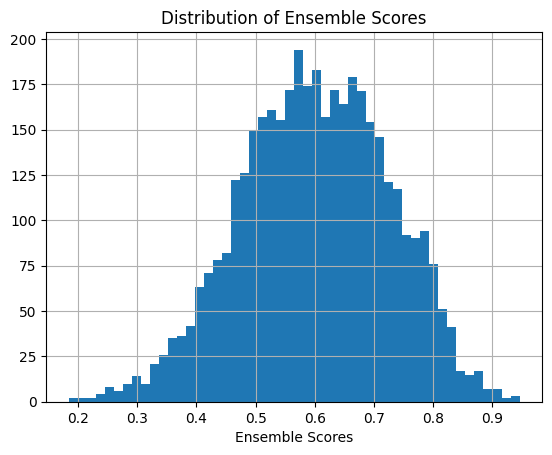

In [ ]:
import matplotlib.pyplot as plt
final_training_data['ensemble_score'].hist(bins=50)
plt.xlabel('Ensemble Scores')
plt.title('Distribution of Ensemble Scores')
plt.show()

In [ ]:
# Use percentiles from your distribution
ensemble_scores = final_training_data['ensemble_score']

# Conservative thresholds (based on histogram)
HIGH_QUALITY_CUTOFF = ensemble_scores.quantile(0.75)    # ~0.75-0.80 range
MEDIUM_QUALITY_CUTOFF = ensemble_scores.quantile(0.5)  # ~0.45-0.50 range
LOW_QUALITY_CUTOFF = ensemble_scores.quantile(0.10)     # ~0.30-0.35 range

print(f"Suggested thresholds:")
print(f"High quality: > {HIGH_QUALITY_CUTOFF:.3f} (top 25%)")
print(f"Medium quality: {MEDIUM_QUALITY_CUTOFF:.3f} - {HIGH_QUALITY_CUTOFF:.3f}")
print(f"Low quality: {LOW_QUALITY_CUTOFF:.3f} - {MEDIUM_QUALITY_CUTOFF:.3f}")
print(f"Very low quality: < {LOW_QUALITY_CUTOFF:.3f} (bottom 10%)")

Suggested thresholds:
High quality: > 0.691 (top 25%)
Medium quality: 0.602 - 0.691
Low quality: 0.437 - 0.602
Very low quality: < 0.437 (bottom 10%)


In [ ]:
# Saving final training data with scores
final_training_data.to_excel("drive/MyDrive/OPUS EN->OC Cleaned Corpus Revised with Ensemble Cleaning.xlsx")

#### 9. Creating tokenized train and val data using the teacher tokenizer

In [ ]:
# 3. TEACHER FINE-TUNING TOKENIZATION
from transformers import AutoTokenizer
from datasets import Dataset # Import the Dataset class

teacher_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.3")
# student_tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

# Add a padding token to the teacher tokenizer
if teacher_tokenizer.pad_token is None:
    teacher_tokenizer.pad_token = teacher_tokenizer.eos_token

teacher_tokenizer.padding_side = "left"

def tokenize_fn(examples, tokenizer_class):
    en_examples = examples['en']
    oc_examples = examples['oc']

    # Build full sequences
    prompts = [f"Translate English to Occitan: {en} -> " for en in en_examples]
    targets = [f"{oc}{tokenizer_class.eos_token}" for oc in oc_examples]
    full_texts = [p + t for p, t in zip(prompts, targets)]

    # Tokenize everything
    tokenized = tokenizer_class(
        full_texts,
        truncation=True,
        max_length=256,
        padding=False, # Remove padding here
        add_special_tokens=False
    )

    # Prepare labels: start with full input_ids
    labels = []
    for i, input_ids in enumerate(tokenized["input_ids"]):
        # Tokenize prompt alone to find its length
        prompt_ids = tokenizer_class(
            prompts[i],
            add_special_tokens=False,  # usually safe, but check your tokenizer
            truncation=False
        )["input_ids"]

        # Create label: -100 for prompt, actual tokens for target
        label = [-100] * len(prompt_ids) + input_ids[len(prompt_ids):]

        # Ensure length matches (in case of truncation)
        if len(label) > len(input_ids):
            label = label[:len(input_ids)]
        elif len(label) < len(input_ids):
            label += [-100] * (len(input_ids) - len(label))

        # In the event of the prompt being too long
        if len(prompt_ids) > 256:
            label = [-100] * len(input_ids)

        labels.append(label)

    tokenized["labels"] = labels
    return tokenized
# Add labels to the output, which are the same as input_ids for causal language modeling
# final_training_data = final_training_data.sort_values(by='ensemble_score', ascending=False)
final_training_data = final_training_data.head(3000)
final_training_data = final_training_data[['en', 'oc']]
# final_training_data = final_training_data.head(3500)
# Convert pandas DataFrame to Hugging Face Dataset
hf_dataset_train = Dataset.from_pandas(final_training_data)
tokenized_train_data = hf_dataset_train.map(tokenize_fn, batched=True, remove_columns=hf_dataset_train.column_names, fn_kwargs={'tokenizer_class': teacher_tokenizer})

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
unusable_val, single_token_val, en_oc_val = init_filtering(dataset_name, config_name, 'validation')
en_oc_val_cleaned, val_changes_log = clean_dataframe_stage_ab(en_oc_val)
en_oc_val_usable = clean_dataframe_stage_c(en_oc_val_cleaned)
en_oc_val_final = pre_laser_final_clean(en_oc_val_usable)
final_val_data = en_oc_val_final.copy()

In [ ]:
unusable_test, single_token_test, en_oc_test = init_filtering(dataset_name, config_name, 'test')
en_oc_test_cleaned, test_changes_log = clean_dataframe_stage_ab(en_oc_test)
en_oc_test_usable = clean_dataframe_stage_c(en_oc_test_cleaned)
en_oc_test_final = pre_laser_final_clean(en_oc_test_usable)
final_test_data = en_oc_test_final.copy()

In [ ]:
early_stop_data = pd.concat([final_val_data, final_test_data]) # Concatenating val and test splits since the number of examples is quite low
early_stop_data['laser_sim'] = early_stop_data.apply(lambda row: calculate_laser_similarity(row['en'], row['oc']), axis=1)
early_stop_data['sbert_sim'] = early_stop_data.apply(lambda row: calculate_sbert_similarity(row['en'], row['oc']), axis=1)

# Use your dataset statistics for normalization
LASER_MEAN = early_stop_data['laser_sim'].mean()
LASER_STD = early_stop_data['laser_sim'].std()
SBERT_MEAN = early_stop_data['sbert_sim'].mean()
SBERT_STD = early_stop_data['sbert_sim'].std()


early_stop_data = combined_rank_generate('laser_sim','sbert_sim', early_stop_data)
early_stop_data['agree_raw'] = early_stop_data[['laser_sim','sbert_sim']].min(axis=1)
early_stop_data['max_raw']   = early_stop_data[['laser_sim','sbert_sim']].max(axis=1)
early_stop_data['sim_rank']  = 0.7*early_stop_data['agree_raw'].rank(pct=True) + \
                                   0.3*early_stop_data['max_raw'].rank(pct=True)

# --- lang prob with clip + temperature + length reliability
eps = 1e-6
oc_p = early_stop_data['oc_score'].clip(eps, 1-eps).to_numpy()
tgt_len = early_stop_data['len_oc_tokens'].to_numpy()

logit = np.log(oc_p/(1-oc_p))/0.8
s = 1/(1+np.exp(-logit))
w = 1.0 - np.exp(-tgt_len/12.0)
early_stop_data['lang_prob_score'] = (1-w)*0.5 + w*s

# --- smoother length score
lr_word = (early_stop_data['len_oc_tokens'] + 1) / (early_stop_data['len_en_tokens'] + 1)
lr_char = (early_stop_data['len_oc'] + 1) / (early_stop_data['len_en'] + 1)
lr = lr_word*0.6 + lr_char*0.4
early_stop_data['length_score'] = np.exp(-1.5*np.abs(np.log(lr))).astype(float)

# --- optional: keep your normalized min embedding (guard std)
LASER_STD = max(LASER_STD, 1e-6); SBERT_STD = max(SBERT_STD, 1e-6)
def norm_sigmoid(x, mean, std):
    return 1/(1+np.exp(-((x-mean)/std)))
early_stop_data['min_embedding_score'] = np.minimum(
    norm_sigmoid(early_stop_data['laser_sim'], LASER_MEAN, LASER_STD),
    norm_sigmoid(early_stop_data['sbert_sim'], SBERT_MEAN, SBERT_STD),
)

# --- ensemble (reduced double-counting)
early_stop_data['ensemble_score'] = (
    0.35*early_stop_data['lang_prob_score'] +
    0.30*early_stop_data['length_score'] +
    0.25*early_stop_data['sim_rank'] +
    0.10*early_stop_data['min_embedding_score']
)
# early_stop_data['laser_sim'] = early_stop_data.apply(lambda row: calculate_sbert_similarity(row['en'], row['oc']), axis=1)
# early_stop_data = early_stop_data.sort_values(by='laser_sim', ascending=False)
# threshold_quantile = early_stop_data['laser_sim'].quantile(0.1)
# early_stop_data = early_stop_data[early_stop_data['laser_sim'] >= threshold_quantile]
# early_stop_data

,orig_idx,en,oc,len_en,len_oc,len_en_tokens,len_oc_tokens,oc_lang_detect,oc_score,cnt_eng_inds,...,laser_sim_rank,sbert_sim_rank,combined_rank,agree_raw,max_raw,sim_rank,lang_prob_score,length_score,min_embedding_score,ensemble_score
3,16,Show space information,Entresenha adicionalas inlistbox Font,22,37,3,4,"{'Portuguese': 0.5389685034751892, 'Occitan': ...",0.350788,0,...,0.057432,0.013514,0.035473,0.167116,0.513582,0.021622,0.448010,0.596719,0.084942,0.349719
5,23,We talked until two.,Qu'am devisat dinc a duas oras.,20,31,4,6,{'Occitan': 0.9999815225601196},0.999982,0,...,0.037162,0.293919,0.165541,0.500258,0.572530,0.202365,0.696734,0.573010,0.132029,0.479554
6,25,I'm short of cash at the moment.,N'èi pas tròp de dinèrs en aque este moment.,32,44,7,9,{'Occitan': 1.0000100135803223},1.000010,0,...,0.469595,0.334459,0.402027,0.605067,0.725594,0.375338,0.763817,0.678214,0.421874,0.606822
7,26,A simple file browser,Un simple explorador de fichièrs,21,32,4,5,{'Occitan': 0.985851526260376},0.985852,0,...,0.722973,0.364865,0.543919,0.640665,0.804995,0.455068,0.668695,0.659385,0.463195,0.591945
11,33,I wish the rain would stop.,M'agradaré que la ploja se estanquèsse.,27,39,6,6,{'Occitan': 0.9839614629745483},0.983961,0,...,0.520270,0.530405,0.525338,0.742255,0.746951,0.563176,0.694456,0.788726,0.539542,0.674426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,1895,Deal a new card from the deck,Distribuissètz una carta mai de el paquet,29,41,7,7,{'Occitan': 0.9786906242370605},0.978691,0,...,0.334459,0.277027,0.305743,0.550524,0.675985,0.293243,0.717317,0.800411,0.360802,0.600575
562,1970,Simulation of Urban MObility,SUMO - SimUlacion de MObilitat Urbana,28,37,4,6,"{'Occitan': 0.4953586161136627, 'Papiamento': ...",0.495359,0,...,0.878378,0.435811,0.657095,0.681862,0.856880,0.566892,0.497717,0.627643,0.511616,0.555378
564,1977,Unable to load resource '%1 ',Impossible de cargar la ressorsa «%1»,29,37,6,6,"{'French': 0.3446643054485321, 'Catalan': 0.31...",0.218578,0,...,0.945946,0.868243,0.907095,0.885977,0.897108,0.928716,0.369776,0.858964,0.742667,0.693557
565,1978,Select New Location,Seleccionar un emplaçament novèl,19,32,3,4,{'Occitan': 0.9990556836128235},0.999056,0,...,0.712838,0.905405,0.809122,0.802879,0.906897,0.810811,0.641687,0.597271,0.661495,0.672624


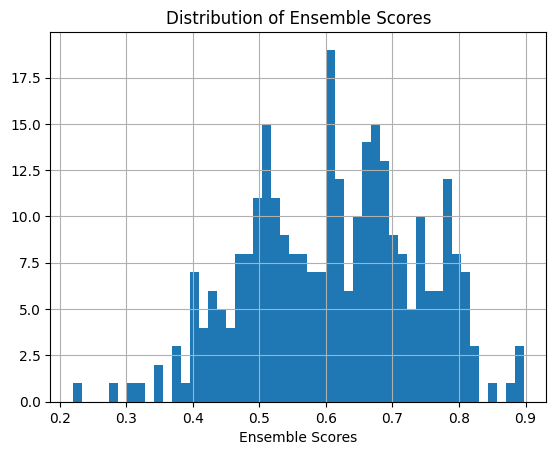

In [ ]:
import matplotlib.pyplot as plt
early_stop_data['ensemble_score'].hist(bins=50)
plt.xlabel('Ensemble Scores')
plt.title('Distribution of Ensemble Scores')
plt.show()

In [ ]:
# Use percentiles from your distribution
ensemble_scores = early_stop_data['ensemble_score']

# Conservative thresholds (based on histogram)
HIGH_QUALITY_CUTOFF = ensemble_scores.quantile(0.75)    # ~0.75-0.80 range
MEDIUM_QUALITY_CUTOFF = ensemble_scores.quantile(0.5)  # ~0.45-0.50 range
LOW_QUALITY_CUTOFF = ensemble_scores.quantile(0.10)     # ~0.30-0.35 range

print(f"Suggested thresholds:")
print(f"High quality: > {HIGH_QUALITY_CUTOFF:.3f} (top 25%)")
print(f"Medium quality: {MEDIUM_QUALITY_CUTOFF:.3f} - {HIGH_QUALITY_CUTOFF:.3f}")
print(f"Low quality: {LOW_QUALITY_CUTOFF:.3f} - {MEDIUM_QUALITY_CUTOFF:.3f}")
print(f"Very low quality: < {LOW_QUALITY_CUTOFF:.3f} (bottom 10%)")

Suggested thresholds:
High quality: > 0.702 (top 25%)
Medium quality: 0.615 - 0.702
Low quality: 0.447 - 0.615
Very low quality: < 0.447 (bottom 10%)


In [ ]:
early_stop_data = early_stop_data.sort_values(by='ensemble_score', ascending=False)
early_stop_data = early_stop_data[['en', 'oc']].head(250)
tokenized_val_data = Dataset.from_pandas(early_stop_data).map(tokenize_fn, batched=True, remove_columns=hf_dataset_train.column_names, fn_kwargs={'tokenizer_class': teacher_tokenizer})

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

#### 10. Finetuning the teacher with initial params and evaluating outputs for sanity check

In [ ]:
# 4. FINE-TUNE TEACHER (Mistral 7B - Quantized)

from transformers import AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForSeq2Seq
from peft import LoraConfig, get_peft_model, LoftQConfig
import torch

# Step 1: Load model with 4-bit quantization using bitsandbytes
from transformers import BitsAndBytesConfig

# Define 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",  # Recommended for better performance
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16  # Saves memory during computation
)

# Load the model directly onto the CUDA device without device_map="auto"
teacher_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.3",
    quantization_config=bnb_config # Forces everything onto GPU
)

# Step 2: Define LoRA config
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA adapter
teacher_model = get_peft_model(teacher_model, lora_config)

# Step 3: Define training arguments
training_args = TrainingArguments(
    output_dir="mistral-7b-teacher",
    per_device_train_batch_size=1,  # Reduce batch size if still OOM
    gradient_accumulation_steps=4,  # Compensate for small batch size
    learning_rate=5e-5,  #Reduced to check if the optimisation is better or not
    num_train_epochs=3,
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch",
    greater_is_better=False,
    fp16=torch.cuda.is_available(),  # Use FP16 if possible
    report_to="none",
    optim="adafactor",
    remove_unused_columns=False, # Add this line to fix the error
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=teacher_tokenizer,
    model=teacher_model,
    padding=True,
    pad_to_multiple_of=8,
    label_pad_token_id=-100  # Ignore padding tokens in the loss
)

# Step 4: Define trainer
trainer = Trainer(
    model=teacher_model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_val_data,
    data_collator=data_collator
)

# Start training
trainer.train()

# Save teacher weights manually for later inference without retraining
trainer.save_model("drive/MyDrive/Mistral-7B-v0.3_3_epochs")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss
1,1.266100,1.750070


Epoch,Training Loss,Validation Loss
1,1.266100,1.750070
2,0.930700,1.600868
3,0.730200,1.603837


In [ ]:
from peft import PeftModel

# Define 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",  # Recommended for better performance
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16  # Saves memory during computation
)

# Load the model directly onto the CUDA device without device_map="auto"
teacher_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.3",
    quantization_config=bnb_config # Forces everything onto GPU
)

# Step 2: Define LoRA config
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

teacher_model = PeftModel.from_pretrained(teacher_model, "drive/MyDrive/Mistral-7B-v0.3_3_epochs")

In [ ]:
# # Check a few training examples
# print("Sample input:", teacher_tokenizer.decode(tokenized_train_data[0]['input_ids']))
# print("Sample labels:", teacher_tokenizer.decode(tokenized_train_data[0]['labels'], skip_special_tokens=True))

# Check if loss was decreasing at all
if hasattr(trainer, 'state'):
    print("Final few losses:", trainer.state.log_history[-5:])

Final few losses: [{'loss': 0.6845, 'grad_norm': 12.256975173950195, 'learning_rate': 5.555555555555556e-07, 'epoch': 2.9733333333333336, 'step': 2230}, {'loss': 0.8006, 'grad_norm': 31.571781158447266, 'learning_rate': 3.3333333333333335e-07, 'epoch': 2.986666666666667, 'step': 2240}, {'loss': 0.7302, 'grad_norm': 13.568294525146484, 'learning_rate': 1.1111111111111112e-07, 'epoch': 3.0, 'step': 2250}, {'eval_loss': 1.603837490081787, 'eval_runtime': 15.171, 'eval_samples_per_second': 16.479, 'eval_steps_per_second': 2.109, 'epoch': 3.0, 'step': 2250}, {'train_runtime': 5060.3914, 'train_samples_per_second': 1.779, 'train_steps_per_second': 0.445, 'total_flos': 1.4044486120833024e+16, 'train_loss': 1.1081567743089464, 'epoch': 3.0, 'step': 2250}]


In [ ]:
from transformers import pipeline

# Create a text generation pipeline
translator = pipeline(
    task="text-generation",
    model=teacher_model,
    tokenizer=teacher_tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

# Test some translations
test_prompts = [
    "Translate English to Occitan: Hello ->",
    "Translate English to Occitan: Good morning ->",
    "Translate English to Occitan: How are you? ->",
    "Translate English to Occitan: I love machine learning ->",
    "Translate English to Occitan: France has many major cities like Paris, Marseille, Bordeaux, etc. ->",
    "Translate English to Occitan: What is your name, Madam? ->",
    "Translate English to Occitan: How is everything at home? ->"
]

if teacher_tokenizer.pad_token_id is None:
    teacher_tokenizer.pad_token_id = teacher_tokenizer.eos_token_id

for prompt in test_prompts:
    result = translator(
        prompt,
        max_new_tokens=40,
        do_sample=False,
        pad_token_id=teacher_tokenizer.pad_token_id,
        eos_token_id=teacher_tokenizer.eos_token_id,
        temperature=0.0
    )
    full_text = result[0]['generated_text']
    # Extract just the generated part
    generated_part = full_text[len(prompt):].split("\n")[0].strip()
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated_part}")
    print("-" * 50)

Device set to use cuda:0


Prompt: Translate English to Occitan: Hello ->
Generated: Salut
--------------------------------------------------
Prompt: Translate English to Occitan: Good morning ->
Generated: Bon matin
--------------------------------------------------
Prompt: Translate English to Occitan: How are you? ->
Generated: Com esi?
--------------------------------------------------
Prompt: Translate English to Occitan: I love machine learning ->
Generated: Amo lo aprendissatge automatic
--------------------------------------------------
Prompt: Translate English to Occitan: France has many major cities like Paris, Marseille, Bordeaux, etc. ->
Generated: La França ai de grans centres coma Paris, Marsilha, Burdeus, etc.
--------------------------------------------------
Prompt: Translate English to Occitan: What is your name, Madam? ->
Generated: Qual es lo nom, Madam?
--------------------------------------------------
Prompt: Translate English to Occitan: How is everything at home? ->
Generated: Quin es l

#### 11. Modifying the FLORES-200 corpus to create the distillation and evaluation splits

In [ ]:
from datasets import Dataset, concatenate_datasets

def create_parallel_dataset(split="dev") -> Dataset:
    flores_en = load_dataset("openlanguagedata/flores_plus", "eng_Latn", split=split).to_pandas()
    flores_oc = load_dataset("openlanguagedata/flores_plus", "oci_Latn", split=split).to_pandas()
    return Dataset.from_dict({
        'en': flores_en['text'],
        'oc': flores_oc['text']
    })

# Create both splits
synthetic_parallel = create_parallel_dataset("dev")
eval_add = Dataset.from_dict(create_parallel_dataset("devtest")[:503])
synthetic_parallel = concatenate_datasets([synthetic_parallel, eval_add])  # Using all of dev and 503 from devtest
eval_parallel = Dataset.from_dict(create_parallel_dataset("devtest")[503:1003])  # For final BLEU, take 500 sentences from remaining devtest

README.md:   0%|          | 0.00/72.5k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

dev/eng_Latn.parquet:   0%|          | 0.00/112k [00:00<?, ?B/s]

devtest/eng_Latn.parquet:   0%|          | 0.00/117k [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/997 [00:00<?, ? examples/s]

Generating devtest split:   0%|          | 0/1012 [00:00<?, ? examples/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

dev/oci_Latn.parquet:   0%|          | 0.00/125k [00:00<?, ?B/s]

devtest/oci_Latn.parquet:   0%|          | 0.00/130k [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/997 [00:00<?, ? examples/s]

Generating devtest split:   0%|          | 0/1012 [00:00<?, ? examples/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

#### 12. Initialising student model with tokenizer and creating distillation pipeline

In [ ]:
# 6. DISTILL TO STUDENT (TinyLlama)
from peft import LoraConfig, get_peft_model
import torch
import torch.nn.functional as F

student_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
student_tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

if student_tokenizer.pad_token is None:
  student_tokenizer.pad_token = student_tokenizer.eos_token

student_tokenizer.padding_side = "left"

# LoRA Config for Efficient Training
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj", "k_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
student_model = get_peft_model(student_model, peft_config)

# class CEDistillationTrainer(Trainer):
#     def __init__(self, teacher_model, student_model, teacher_tokenizer, student_tokenizer, examples):
#         super().__init__(teacher_model, student_model, teacher_tokenizer, student_tokenizer, examples)

#     def tokenize_data(self, examples, tokenizer):
#         tokenized_data = tokenize_fn(examples, tokenizer)
#         return tokenized_data

#     def DistillConfig(self, distill_config):

#     def teacher_cross_entropy(self, teacher_model, batch_tokens):
#         input_ids = batch_tokens['input_ids'].to(device)
#         attention_mask = batch_tokens['attention_mask'].to(device)
#         labels = batch_tokens['labels'].to(device)
#         with torch.no_grad():
#             outputs = teacher_model(input_ids, attention_mask=attention_mask, labels=labels)
#             logits = outputs.logits[:, :-1, :]
#             labels = labels[:, 1:]
#             mask = labels != -100
#             p_T = F.softmax(logits / T, dim=-1)
#             gold = labels.clone()
#             gold[gold == -100] = 0
#             p_gold = p_T.gather(-1, gold.unsqueeze(-1)).squeeze(-1)
#             ll = (p_gold.clamp_min(eps).log() * mask).sum(1) / mask.sum(1).clamp_min(1)
#             conf = torch.sigmoid(ll)
#         return conf.cpu()



config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [ ]:
from dataclasses import dataclass
from typing import Optional, Callable, Dict, List
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import Trainer, TrainingArguments, default_data_collator, DataCollatorForSeq2Seq # Import DataCollatorForSeq2Seq

# --------------------
# Config
# --------------------
@dataclass
class DistillConfig:
    optim: str = "adafactor" # Could be changed to adam since the student model has less of a size issue
    max_length: int = 256
    min_target_tokens: int = 8
    batch_size: int = 1 # Reduced batch size per device due to low number of training examples
    grad_accum: int = 4
    learning_rate: float = 1e-5 # Reduced learning rate to see if gradient descent might be overshooting
    num_train_epochs: int = 3 # Kept similar to teacher, should be reduced due to low number of examples if overfitting is seen
    temperature: float = 2.0
    conf_floor: float = 0.2
    report_to: str = "none"
    fp16: bool = True
    add_special_tokens: bool = False
    prompt_template: str = "Translate English to Occitan: {src} -> "


# --------------------
# Distillation Trainer
# --------------------
class CEDistillationTrainer(Trainer):
    """
    Student-side Trainer that applies sentence-level teacher confidence weights
    to the student's cross-entropy loss. Tokenizers can differ between teacher and student.

    Usage:
      1) Build teacher_tokenized Dataset and student_tokenized Dataset over the SAME raw order.
      2) Call `precompute_teacher_confidence(teacher_model, teacher_dataset, ...)`.
      3) Add the returned weights to the student dataset as a 'sent_weight' column.
      4) Initialize this Trainer with the student model + student dataset and train.
    """

    def __init__(
        self,
        student_model,
        args: TrainingArguments,
        train_dataset,                      # student-tokenized dataset including 'sent_weight'
        tok, # teacher tokenizer for precomputation, student tokenizer is used separately in the TrainingArguments method when using data_collator
        eval_dataset=None,
        data_collator=default_data_collator,
        # teacher pieces for optional on-the-fly confidence or caching (precompute is preferred)
        teacher_model=None,
        teacher_dataset=None,
        distill_config: DistillConfig = DistillConfig()
    ):
        super().__init__(
            model=student_model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            data_collator=data_collator
        )
        self.teacher_model = teacher_model
        self.teacher_dataset = teacher_dataset
        self.cfg = distill_config
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Use DataCollatorForSeq2Seq for teacher confidence calculation using the teacher tokenizer
        self.teacher_data_collator = DataCollatorForSeq2Seq(
            tokenizer=tok,
            model=teacher_model,
            padding=True,
            pad_to_multiple_of=8,
            label_pad_token_id=-100
        )


    # --------------------
    # Teacher confidence (precompute once; recommended)
    # --------------------
    def precompute_teacher_confidence(
        self,
        batch_size: Optional[int] = None,
        temperature: Optional[float] = None,
    ) -> np.ndarray:
        """
        Compute sentence-level confidence from the (frozen) teacher on the teacher-tokenized dataset.
        Returns an array of shape [N] aligned to dataset order.
        """
        assert self.teacher_model is not None, "teacher_model is required"
        assert self.teacher_dataset is not None, "teacher_dataset is required"

        T = float(temperature if temperature is not None else self.cfg.temperature)
        eps = 1e-8
        self.teacher_model.eval().to(self._device)

        loader = DataLoader(
            self.teacher_dataset,
            batch_size=batch_size or self.cfg.batch_size,
            shuffle=False,
            collate_fn=self.teacher_data_collator, # Use the dedicated teacher data collator
        )

        confs = []
        with torch.no_grad():
            for batch in loader:
                input_ids = batch["input_ids"].to(self._device)
                attn = batch.get("attention_mask", None)
                if attn is not None:
                    attn = attn.to(self._device)
                labels = batch["labels"].to(self._device)

                out = self.teacher_model(input_ids=input_ids, attention_mask=attn, labels=labels)
                logits = out.logits[:, :-1, :]       # [B, L-1, V]
                labels_shift = labels[:, 1:]         # [B, L-1]
                mask = (labels_shift != -100)

                p_t = F.softmax(logits / T, dim=-1)
                gold = labels_shift.clone()
                gold[gold == -100] = 0              # placeholder for gather
                p_gold = p_t.gather(-1, gold.unsqueeze(-1)).squeeze(-1)  # [B, L-1]

                # length-normalized mean log-prob on valid tokens
                ll = (p_gold.clamp_min(eps).log() * mask).sum(dim=1) / mask.sum(dim=1).clamp_min(1)
                conf = torch.sigmoid(ll)            # map to [0,1]
                confs.append(conf.cpu())

        conf = torch.cat(confs).numpy()
        conf = np.clip(conf, self.cfg.conf_floor, 1.0)
        return conf

    # --------------------
    # Student loss (weighted CE)
    # --------------------
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        inputs must include:
          - input_ids, attention_mask (optional), labels  (student-tokenized)
          - sent_weight (float tensor or list)           (aligned sentence weights)
        """
        # Pull sentence weights (teacher confidence or combo)
        assert "sent_weight" in inputs, "sent_weight not in inputs"
        w = inputs.pop("sent_weight")
        outputs = model(**inputs)
        logits = outputs.logits[:, :-1, :]              # [B, L-1, V]
        labels = inputs["labels"][:, 1:]                # [B, L-1]
        mask = (labels != -100)

        ce_tok = F.cross_entropy(
            logits.reshape(-1, logits.size(-1)),
            labels.reshape(-1),
            ignore_index=-100,
            reduction="none"
        ).view(labels.size())                           # [B, L-1]

        sent_loss = (ce_tok * mask).sum(dim=1) / mask.sum(dim=1).clamp_min(1)

        if not isinstance(w, torch.Tensor):
            w = torch.tensor(w, device=sent_loss.device, dtype=sent_loss.dtype)
        else:
            w = w.to(sent_loss.device, dtype=sent_loss.dtype)

        loss = (sent_loss * w).mean()
        return (loss, outputs) if return_outputs else loss


# --------------------
# Helper: build tokenized datasets with your tokenize_fn
# (same prompt masking logic, different tokenizers)
# --------------------
def build_teacher_student_datasets(
    raw: Dataset,
    tokenize_fn: Callable,
    teacher_tokenizer,
    student_tokenizer
    # cfg: DistillConfig,
) -> List[Dataset]:
    """
    raw must contain columns: 'en', 'oc' (same order is preserved).
    Returns (teacher_ds, student_ds) with fields: input_ids, labels (and attention_mask via collator).
    """
    if "idx" not in raw.column_names:
        raw = raw.add_column("idx", list(range(len(raw))))

    for tok in [teacher_tokenizer, student_tokenizer]:
        if tok.pad_token is None:
            tok.pad_token = tok.eos_token
        tok.padding_side = "left"   # Added to avoid issues in training the causal models

    def tok_teacher(ex):
        return tokenize_fn(
            {"en": ex["en"], "oc": ex["oc"]},
            tokenizer_class=teacher_tokenizer
            # max_length=cfg.max_length,
            # min_target_tokens=cfg.min_target_tokens,
            # prompt_template=cfg.prompt_template,
            # add_special_tokens=cfg.add_special_tokens,
        )

    def tok_student(ex):
        return tokenize_fn(
            {"en": ex["en"], "oc": ex["oc"]},
            tokenizer_class=student_tokenizer
            # max_length=cfg.max_length,
            # min_target_tokens=cfg.min_target_tokens,
            # prompt_template=cfg.prompt_template,
            # add_special_tokens=cfg.add_special_tokens,
        )

    teacher_ds = raw.map(tok_teacher, batched=True, remove_columns=[c for c in raw.column_names if c == "en" or c == "oc"])
    student_ds = raw.map(tok_student, batched=True, remove_columns=[c for c in raw.column_names if c == "en" or c == "oc"])
    return [teacher_ds, student_ds]

In [ ]:
# 1) Tokenize for teacher & student
cfg = DistillConfig()
teacher_ds, student_ds = build_teacher_student_datasets(
    synthetic_parallel, tokenize_fn, teacher_tokenizer, student_tokenizer
)

# 2) Precompute teacher confidence once
trainer_stub = CEDistillationTrainer(
    student_model=student_model,
    args=TrainingArguments(
        output_dir="tinyllama-student-distill",
        per_device_train_batch_size=cfg.batch_size,
        gradient_accumulation_steps=cfg.grad_accum,
        learning_rate=cfg.learning_rate,
        num_train_epochs=cfg.num_train_epochs,
        logging_steps=50,
        save_strategy="epoch",
        eval_strategy="no",
        fp16=cfg.fp16,
        report_to=cfg.report_to,
        optim=cfg.optim,
        remove_unused_columns=False
    ),
    train_dataset=None,  # set later
    teacher_model=teacher_model,
    teacher_dataset=teacher_ds,
    distill_config=cfg,
    tok=teacher_tokenizer # Pass teacher_tokenizer to the trainer_stub
)

conf = trainer_stub.precompute_teacher_confidence()            # numpy [N]
conf = np.clip(conf, cfg.conf_floor, 1.0)

# (Optional) multiply by your ensemble weights from data filtering:
# conf = np.clip(conf * ensemble_weights, 0.05, 1.0)

# 3) Attach weights to student dataset
student_ds = student_ds.add_column("sent_weight", conf.tolist())

# 4) Train student (now build the real trainer)
trainer = CEDistillationTrainer(
    student_model=student_model,
    args=TrainingArguments(
        output_dir="tinyllama-student-distill",
        per_device_train_batch_size=cfg.batch_size,
        gradient_accumulation_steps=cfg.grad_accum,
        learning_rate=cfg.learning_rate,
        num_train_epochs=cfg.num_train_epochs,
        logging_steps=50,
        save_strategy="epoch",
        eval_strategy="no",
        fp16=cfg.fp16,
        report_to=cfg.report_to,
        remove_unused_columns=False
    ),
    train_dataset=student_ds,
    eval_dataset=None,
    data_collator=DataCollatorForSeq2Seq(
        tokenizer=student_tokenizer,
        model=student_model,
        padding=True,
        pad_to_multiple_of=8,
        label_pad_token_id=-100
    ), # Use DataCollatorForSeq2Seq for the main trainer
    tok=teacher_tokenizer,
    distill_config=cfg,
)

trainer.train()

trainer.save_model("drive/MyDrive/Mistral-7B-v0.3_3_epochs")

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Step,Training Loss
50,2.399800
100,2.381100
150,2.391100
200,2.353300
250,2.408300
300,2.312900
350,2.313500
400,2.367700
450,2.346400
500,2.265700


#### 13. Generating final translations for eval with BLEU and chrF scores

In [ ]:
from tqdm import tqdm

def generate_translations_for_eval(model, texts, tokenizer, batch_size=8, model_type="causal", lang_code="oci"):
    processed_outputs = []
    total = len(texts['en'])
    model.eval().to("cuda")

    with torch.inference_mode():
        for i in tqdm(range(0, total, batch_size), desc="Generating"):
            en_batch = texts['en'][i:i + batch_size]
            oc_gold_batch = texts['oc'][i:i + batch_size]

            if model_type == "causal":
                prompts = [f"Translate English to Occitan: {en} -> " for en in en_batch]

                if tokenizer.pad_token_id is None:
                    tokenizer.pad_token_id = tokenizer.eos_token_id

                tokenizer.padding_side = "left"

                inputs = tokenizer(
                    prompts,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=256
                ).to("cuda")

                outputs = model.generate(
                    **inputs,
                    max_new_tokens=128,
                    pad_token_id=tokenizer.pad_token_id,
                    do_sample=False,
                    num_beams=5,
                    # early_stopping=True,
                    # length_penalty=1.0,
                    eos_token_id=tokenizer.eos_token_id
                    # no_repeat_ngram_size=4,
                    # repetition_penalty=1.5
                )

                decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

                for src, gold_oc, gen_text in zip(en_batch, oc_gold_batch, decoded):
                    # Strip prompt
                    prompt = f"Translate English to Occitan: {src} -> "
                    trans = gen_text.replace(prompt, '', 1).split("\n")[0].strip()
                    trans = trans.rstrip(" .,;:")

                    processed_outputs.append({
                    "en": src,
                    "oc_gold": gold_oc,
                    "oc_synthetic": trans
                    })

            elif model_type == "seq2seq":
                input_batch = [f">>{lang_code}<< {src}" for src in en_batch]

                if tokenizer.pad_token_id is None:
                    tokenizer.pad_token_id = tokenizer.eos_token_id

                tokenizer.padding_side = "right"

                inputs =  tokenizer(
                    input_batch,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=256
                ).to("cuda")

                outputs = model.generate(
                    **inputs,
                    max_new_tokens=128,
                    pad_token_id=tokenizer.pad_token_id,
                    do_sample=False,
                    num_beams=5,
                    eos_token_id=tokenizer.eos_token_id
                )

                decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

                for src, gold_oc, trans in zip(en_batch, oc_gold_batch, decoded):
                    # Strip prompt
                    # prompt = f"Translate English to Occitan: {src} -> "
                    # trans = gen_text.replace(prompt, '', 1).strip()
                    # trans = trans.rstrip(" .,;:")
                    trans = trans.strip()

                    processed_outputs.append({
                    "en": src,
                    "oc_gold": gold_oc,
                    "oc_synthetic": trans
                    })

            if i % 20 == 0:
                torch.cuda.empty_cache()

    torch.cuda.empty_cache()
    return processed_outputs

In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.3 MB/s eta 0:00:00


In [ ]:
import sacrebleu

def score_bleu_chrf(trans_dict, label="system"):
    hyps = [t["oc_synthetic"] for t in trans_dict]
    refs = [t["oc_gold"] for t in trans_dict]
    assert len(hyps) == len(refs), f"len mismatch: {len(hyps)} vs {len(refs)}"
    bleu = sacrebleu.corpus_bleu(hyps, [refs])
    chrf = sacrebleu.corpus_chrf(hyps, [refs])
    print(f"[{label}] BLEU: {bleu.score:.2f} | chrF: {chrf.score:.2f}")
    print("sacreBLEU signature:", bleu) # Modified to print the object directly
    return {"bleu": bleu.score, "chrf": chrf.score, "sig": bleu}

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

model_name = "Helsinki-NLP/opus-mt-tc-big-en-cat_oci_spa"
marian_tokenizer = MarianTokenizer.from_pretrained(model_name)
marian_model = MarianMTModel.from_pretrained(model_name)

# Teacher (causal)
trans_teacher = generate_translations_for_eval(teacher_model, eval_parallel, teacher_tokenizer, batch_size=10, model_type="causal")
m_teacher = score_bleu_chrf(trans_teacher, label="Teacher")

# Student (causal)
trans_student = generate_translations_for_eval(student_model, eval_parallel, student_tokenizer, batch_size=10, model_type="causal")
m_student = score_bleu_chrf(trans_student, label="Student")

# Baseline (Marian)
trans_base = generate_translations_for_eval(marian_model, eval_parallel, marian_tokenizer, batch_size=10, model_type="seq2seq", lang_code="oci")
m_base = score_bleu_chrf(trans_base, label="Helsinki")

Generating:   8%|▊         | 4/50 [02:52<32:59, 43.03s/it]


KeyboardInterrupt: 

#### Optional: Debugging student translations due to low BLEU scores

In [ ]:
# Precompile a regex for common emoji/flag ranges
EMOJI_PATTERN = re.compile(
    "["
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "\U000024C2-\U0001F251"  # Enclosed characters
    "]+",
    flags=re.UNICODE,
)

def contains_emoji_or_flag(text: str) -> bool:
    return bool(EMOJI_PATTERN.search(text))

def is_degenerate_output(text: str) -> bool:
    text = text.strip()
    if not text:
        return True
    if len(text) < 2:
        return True
    if contains_emoji_or_flag(text):
        return True
    # Optional: check if mostly non-letter
    letters = sum(c.isalpha() for c in text)
    return (letters / len(text)) < 0.5

cnt = 0
trans_student_copy = trans_student.copy()
for d in trans_student_copy:
    if is_degenerate_output(d['oc_synthetic']):
        cnt += 1
        d['oc_synthetic'] = ""


m_student_rev = score_bleu_chrf(trans_student_copy, label="Student_Revised")

trans_student_trunc = [d for d in trans_student if not is_degenerate_output(d['oc_synthetic'])]
m_student_trunc = score_bleu_chrf(trans_student_trunc, label="Student_Truncated")

Generating: 100%|██████████| 50/50 [06:08<00:00,  7.37s/it]


[Student] BLEU: 6.36 | chrF: 35.61
sacreBLEU signature: BLEU = 6.36 28.7/9.2/3.7/1.7 (BP = 1.000 ratio = 1.018 hyp_len = 13729 ref_len = 13480)
[Student_Revised] BLEU: 4.56 | chrF: 27.49
sacreBLEU signature: BLEU = 4.56 22.5/6.9/2.8/1.2 (BP = 0.948 ratio = 0.949 hyp_len = 12795 ref_len = 13480)
[Student_Truncated] BLEU: 6.37 | chrF: 36.33
sacreBLEU signature: BLEU = 6.37 28.7/9.2/3.7/1.7 (BP = 1.000 ratio = 1.043 hyp_len = 13677 ref_len = 13110)
